In [2]:
# Google Colab allows you to access your Google drive on interavtive environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing the data
import pandas as pd

mlb_stats = pd.read_excel("/content/drive/MyDrive/2024 MLB Batting Stats.xlsx")

print(mlb_stats.head())
print(mlb_stats.info())


              Name Team Pos    G   PA  HR    R  RBI  SB    BB%  ...    AVG  \
0      Aaron Judge  NYY  OF  158  704  58  122  144  10  0.189  ...  0.322   
1  Adley Rutschman  BAL   C  148  638  19   68   79   1  0.091  ...  0.250   
2    Adolis García  TEX  OF  154  637  25   68   85  11  0.071  ...  0.224   
3        Alec Bohm  PHI  3B  143  606  15   62   97   5  0.066  ...  0.280   
4    Alec Burleson  STL  DH  152  595  21   71   78   9  0.059  ...  0.269   

     OBP    SLG  BsR   Off   Def   WAR  BB/K    OPS  Spd  
0  0.458  0.701 -0.4  95.0  -9.9  11.2  0.78  1.159  3.9  
1  0.318  0.391 -2.9  -0.2   6.5   2.8  0.56  0.709  2.1  
2  0.284  0.400 -0.7  -6.6 -17.0  -0.2  0.25  0.684  3.5  
3  0.332  0.448 -2.6   8.1   5.7   3.5  0.47  0.779  3.4  
4  0.314  0.420 -3.1   0.9 -14.8   0.6  0.46  0.735  3.4  

[5 rows x 23 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------ 

In [4]:
missing = mlb_stats.isnull().any().any()
print(missing)


False


No missing values!

In [5]:
position_counts = mlb_stats['Pos'].value_counts()
print(position_counts)


Pos
OF    43
1B    22
2B    17
3B    16
SS    16
C      9
DH     6
Name: count, dtype: int64


In [6]:
def categorize_pos(pos):
    if pos == 'OF':
        return 'OF'
    elif pos in ['2B', 'SS']:
        return 'MI'
    elif pos in ['3B', '1B']:
        return 'CI'
    elif pos in ['DH', 'C']:
        return 'C_DH'
    else:
        return 'Other'  # For any positions not explicitly mentioned

# Create the new column
mlb_stats['pos_cat'] = mlb_stats['Pos'].apply(categorize_pos)

position_counts2 = mlb_stats['pos_cat'].value_counts()
print(position_counts2)


pos_cat
OF      43
CI      38
MI      33
C_DH    15
Name: count, dtype: int64


In [7]:
### Andrew's code to remove small groups to make the datset more balanced ###
mlb_stats2 = mlb_stats[mlb_stats['pos_cat'] != 'C_DH']
new_position_counts = mlb_stats2['pos_cat'].value_counts()
print(new_position_counts)

pos_cat
OF    43
CI    38
MI    33
Name: count, dtype: int64


In [8]:
import scipy.stats as stats
import numpy as np

# List of dependent variables to check
dep_vars = ['HR', 'AVG', 'WAR', 'RBI', 'Def', 'BB/K', 'Spd', 'BABIP']

# Group data by position category
grouped = mlb_stats2.groupby('pos_cat')

# Loop through each group and perform Shapiro-Wilk test for each dependent variable
for group_name, group_data in grouped:
    print(f"Testing normality for position group: {group_name}")
    for var in dep_vars:
        stat, p_value = stats.shapiro(group_data[var])
        print(f"{var}: W={stat:.3f}, p={p_value:.3f}")
        if p_value < 0.05:
            print(f"  → {var} is NOT normally distributed (p < 0.05)")
        else:
            print(f"  → {var} is normally distributed (p ≥ 0.05)")
    print("-" * 40)


Testing normality for position group: CI
HR: W=0.973, p=0.485
  → HR is normally distributed (p ≥ 0.05)
AVG: W=0.967, p=0.318
  → AVG is normally distributed (p ≥ 0.05)
WAR: W=0.976, p=0.572
  → WAR is normally distributed (p ≥ 0.05)
RBI: W=0.975, p=0.535
  → RBI is normally distributed (p ≥ 0.05)
Def: W=0.957, p=0.157
  → Def is normally distributed (p ≥ 0.05)
BB/K: W=0.981, p=0.767
  → BB/K is normally distributed (p ≥ 0.05)
Spd: W=0.933, p=0.025
  → Spd is NOT normally distributed (p < 0.05)
BABIP: W=0.987, p=0.920
  → BABIP is normally distributed (p ≥ 0.05)
----------------------------------------
Testing normality for position group: MI
HR: W=0.969, p=0.450
  → HR is normally distributed (p ≥ 0.05)
AVG: W=0.957, p=0.215
  → AVG is normally distributed (p ≥ 0.05)
WAR: W=0.885, p=0.002
  → WAR is NOT normally distributed (p < 0.05)
RBI: W=0.911, p=0.010
  → RBI is NOT normally distributed (p < 0.05)
Def: W=0.942, p=0.079
  → Def is normally distributed (p ≥ 0.05)
BB/K: W=0.965, p=0

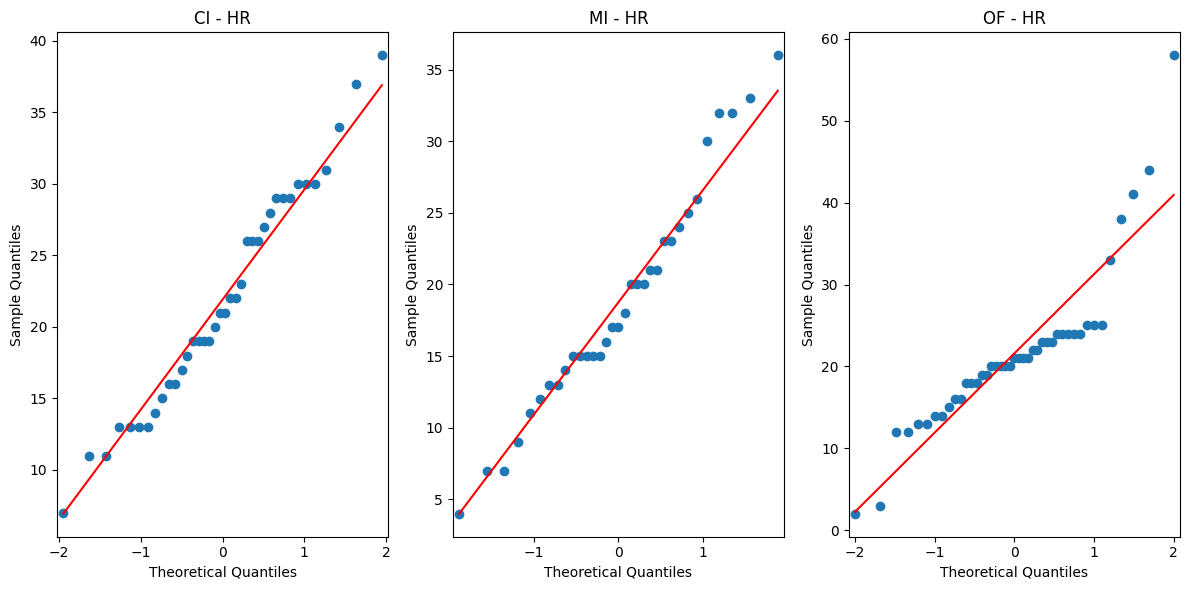

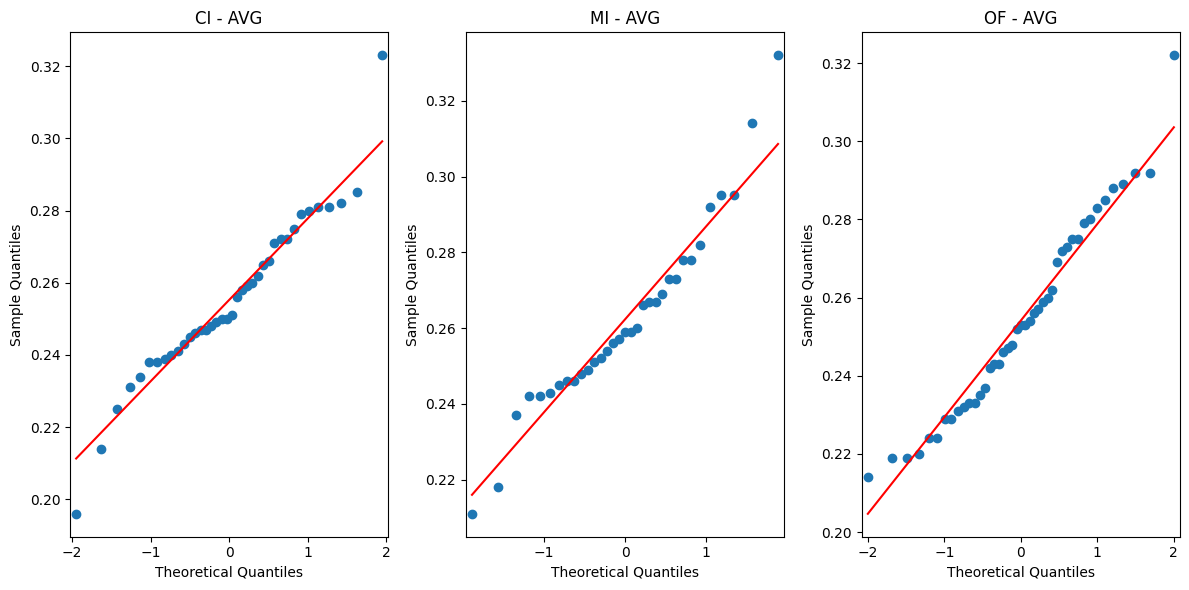

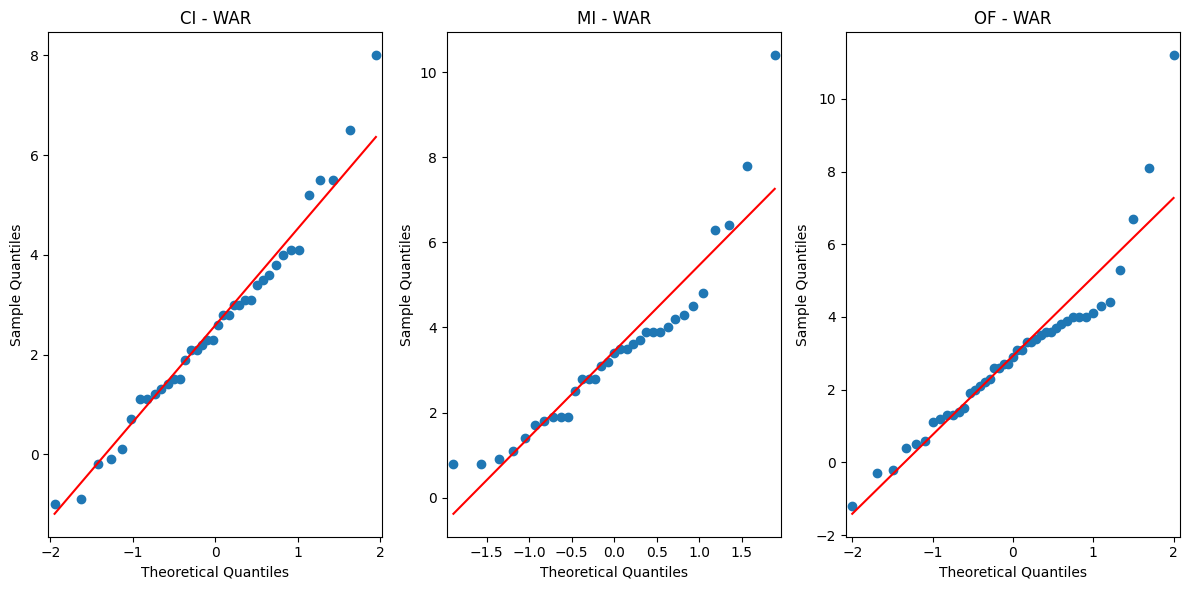

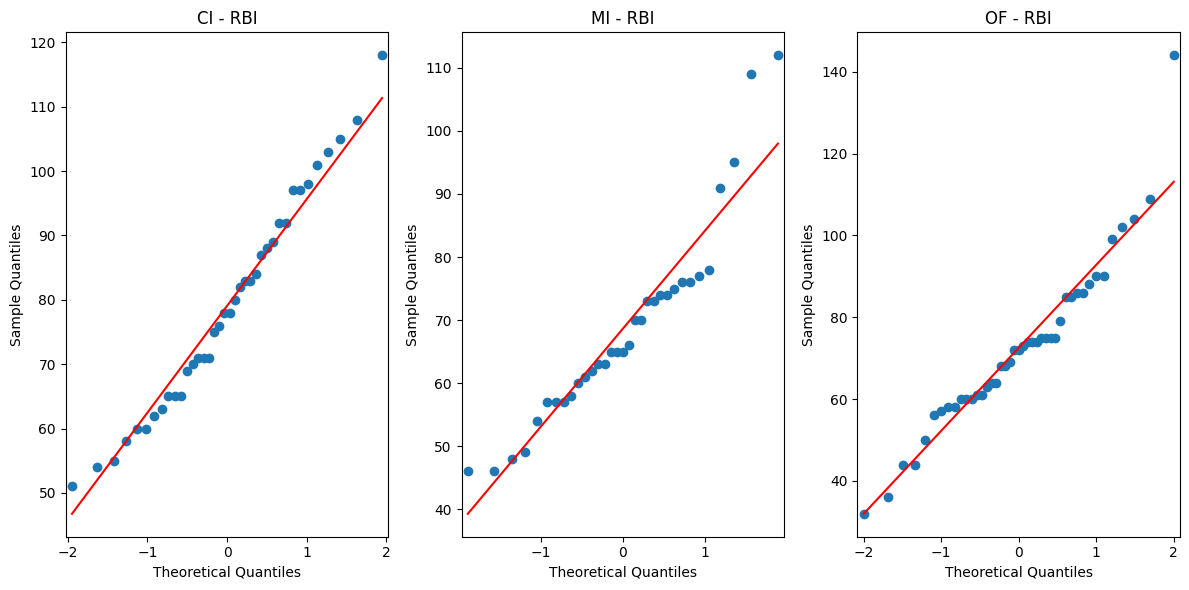

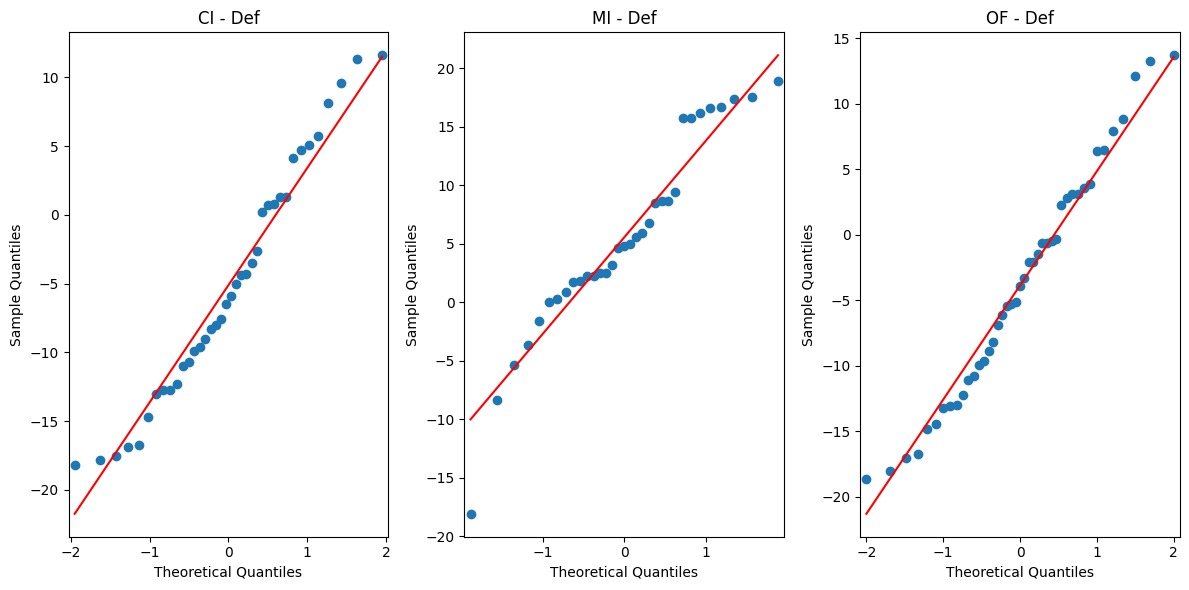

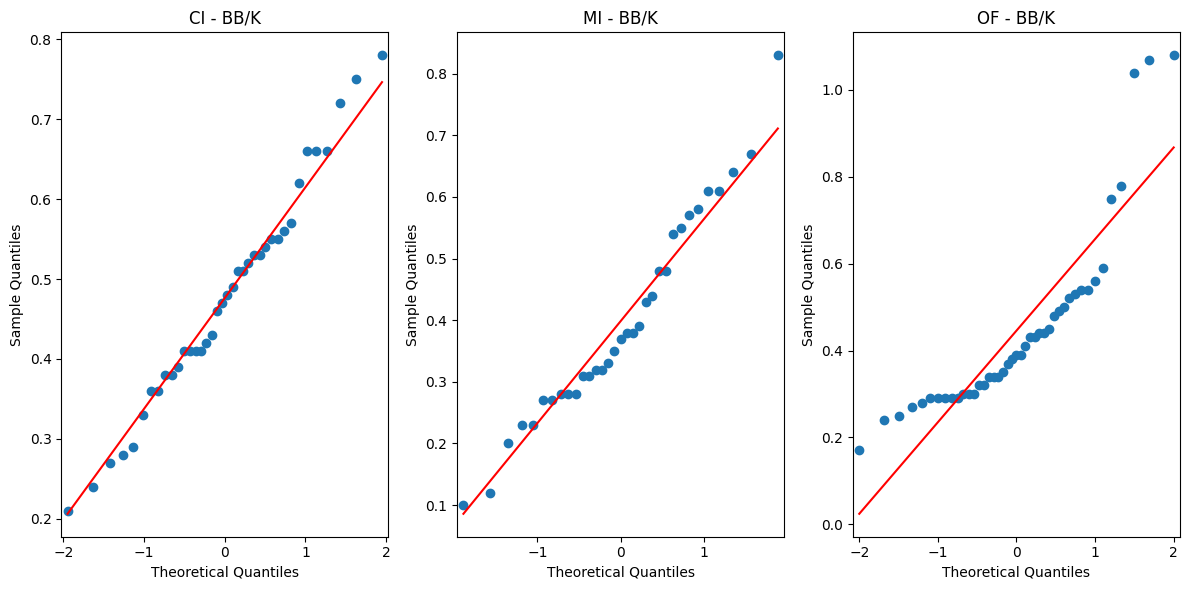

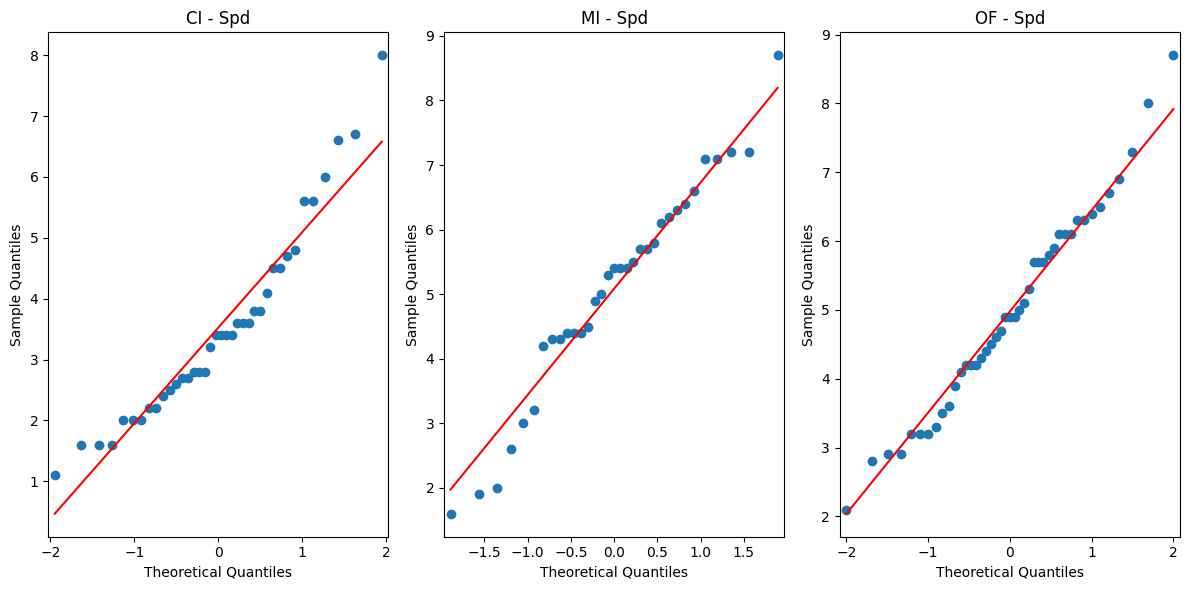

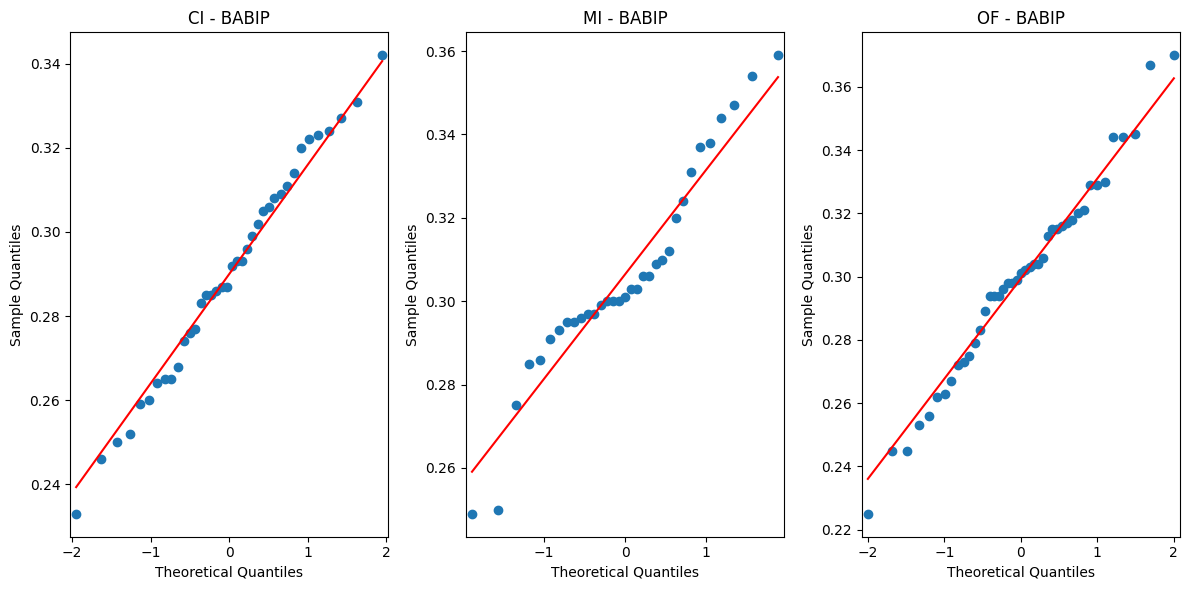

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Generate Q-Q plots for each variable within each pos_cat group
for var in dep_vars:
    plt.figure(figsize=(12, 6))
    for i, (group_name, group_data) in enumerate(grouped):
        plt.subplot(1, len(grouped), i + 1)
        sm.qqplot(group_data[var], line='s', ax=plt.gca())
        plt.title(f"{group_name} - {var}")
    plt.tight_layout()
    plt.show()


In [10]:
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# Calculate Mahalanobis distance for each observation
def mahalanobis_distance(df, dep_vars):
    mean_vec = np.mean(df[dep_vars], axis=0)
    cov_matrix = np.cov(df[dep_vars], rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    distances = []
    for index, row in df[dep_vars].iterrows():
        distances.append(mahalanobis(row, mean_vec, inv_cov_matrix))

    return np.array(distances)

# Apply Mahalanobis distance calculation
mlb_stats['mahalanobis'] = mahalanobis_distance(mlb_stats, dep_vars)

# Identify potential outliers (top 5%)
threshold = np.percentile(mlb_stats['mahalanobis'], 95)
outliers = mlb_stats[mlb_stats['mahalanobis'] > threshold]

# Display outliers
print("Potential Outliers (Top 5% of Mahalanobis Distance):")
print(outliers[['Name', 'Pos', 'pos_cat', 'mahalanobis']].head())


Potential Outliers (Top 5% of Mahalanobis Distance):
                 Name Pos pos_cat  mahalanobis
0         Aaron Judge  OF      OF     4.990195
11  Anthony Santander  OF      OF     4.304466
68          Juan Soto  OF      OF     4.193057
78        Luis Arraez  2B      MI     4.663809
89       Mookie Betts  OF      OF     5.150177


In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.multivariate.manova import MANOVA

# Function to compute Box's M test
def box_m_test(df, dep_vars, group_col):
    groups = df[group_col].unique()
    cov_matrices = [df[df[group_col] == group][dep_vars].cov().values for group in groups]

    pooled_cov = sum(cov_matrices) / len(groups)  # Average covariance matrix
    inv_pooled_cov = np.linalg.inv(pooled_cov)  # Inverse of pooled covariance matrix

    log_dets = [np.log(np.linalg.det(cov)) for cov in cov_matrices]
    log_det_pooled = np.log(np.linalg.det(pooled_cov))

    n = [len(df[df[group_col] == group]) for group in groups]
    p = len(dep_vars)
    k = len(groups)

    # Compute Box's M statistic
    M = (sum(n) - k) * log_det_pooled - sum([(n[i] - 1) * log_dets[i] for i in range(k)])
    c = ((2 * p**2 + 3 * p - 1) * (k - 1)) / (6 * (p + 1) * (sum(n) - k))
    chi_square = M * (1 - c)
    df = (p * (p + 1) * (k - 1)) / 2
    p_value = 1 - stats.chi2.cdf(chi_square, df)

    return M, chi_square, df, p_value

# Run Box's M test
M_stat, chi2_stat, df, p_val = box_m_test(mlb_stats, dep_vars, 'pos_cat')

# Print results
print(f"Box's M Test Results:")
print(f"M Statistic: {M_stat:.3f}")
print(f"Chi-Square Statistic: {chi2_stat:.3f}")
print(f"Degrees of Freedom: {df}")
print(f"P-value: {p_val:.5f}")

# Interpretation
if p_val < 0.05:
    print("→ The assumption of homogeneity of covariance matrices is VIOLATED (p < 0.05).")
else:
    print("→ The assumption of homogeneity of covariance matrices is MET (p ≥ 0.05).")


Box's M Test Results:
M Statistic: 180.149
Chi-Square Statistic: 168.059
Degrees of Freedom: 108.0
P-value: 0.00019
→ The assumption of homogeneity of covariance matrices is VIOLATED (p < 0.05).


In [12]:
#Check independent variables
#Check multicolinearity
#Check outliers where residuals are more than 3 STD
#Check normality and then take log if needed.
#Probably boxcox, VIF values, dropping more than one


#Capping and flooring outliers with the 99 percentile


In [13]:
#Checking for outliers using interquartile range

## Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

outliers = detect_outliers_iqr(mlb_stats, ['Def', 'BB/K', 'Spd', 'BABIP'])
for var, data in outliers.items():
    print(f"Outliers in {var}:\n", data)


Outliers in Def:
 Series([], Name: Def, dtype: float64)
Outliers in BB/K:
 68     1.08
89     1.07
111    1.04
Name: BB/K, dtype: float64
Outliers in Spd:
 Series([], Name: Spd, dtype: float64)
Outliers in BABIP:
 Series([], Name: BABIP, dtype: float64)


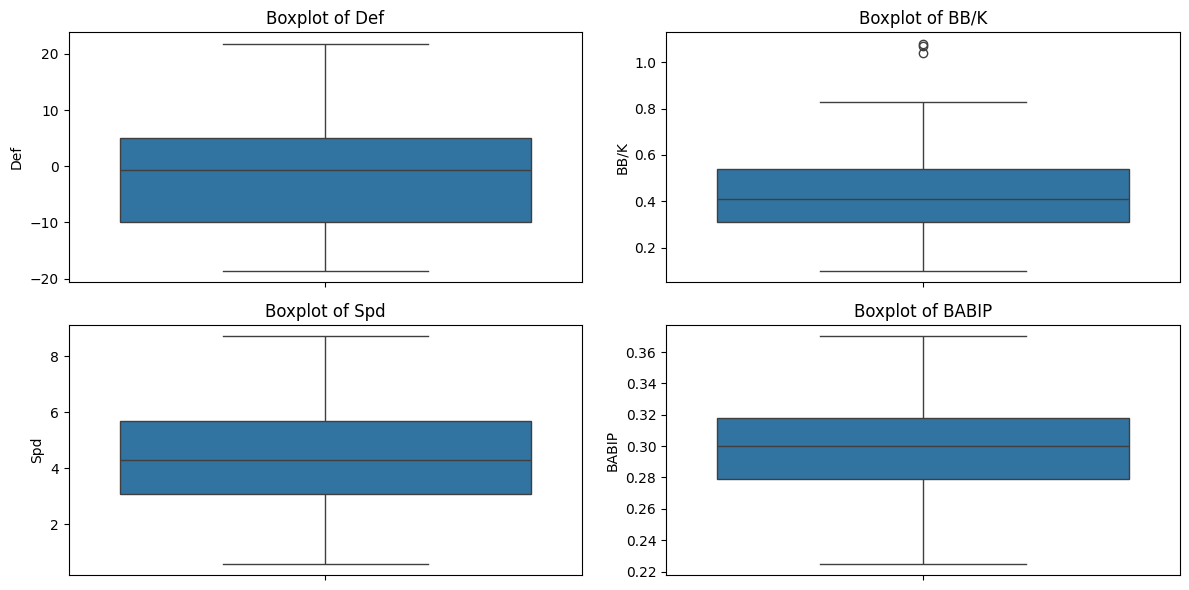

In [14]:
## Using boxplots to visually check the outliers

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for i, col in enumerate(['Def', 'BB/K', 'Spd', 'BABIP'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=mlb_stats[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


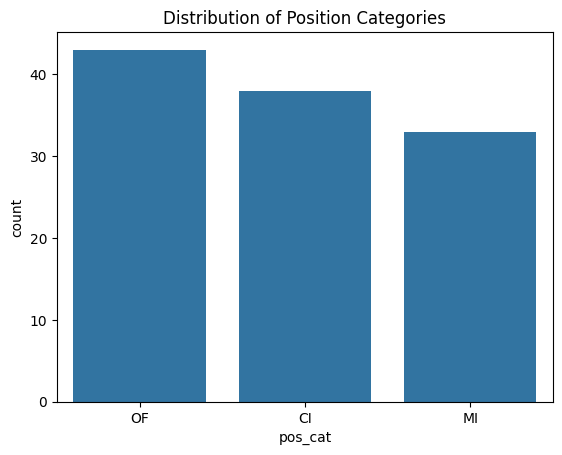

pos_cat
OF    43
CI    38
MI    33
Name: count, dtype: int64


In [15]:
#Verifyinh the independent variables(pos_cat)

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=mlb_stats2['pos_cat'])
plt.title("Distribution of Position Categories")
plt.show()

print(mlb_stats2['pos_cat'].value_counts())

In [16]:
## Log Transformation of the normality violation

mlb_stats2['Spd_log'] = np.log(mlb_stats2['Spd'] + 1)  # Add 1 to avoid log(0)
mlb_stats2['BB_K_log'] = np.log(mlb_stats2['BB/K'] + 1)


<ipython-input-16-44c667072f54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlb_stats2['Spd_log'] = np.log(mlb_stats2['Spd'] + 1)  # Add 1 to avoid log(0)
<ipython-input-16-44c667072f54>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlb_stats2['BB_K_log'] = np.log(mlb_stats2['BB/K'] + 1)


In [17]:
## Re-running the Wilk test after applying the log transformation
import scipy.stats as stats
import numpy as np

# List of transformed dependent variables to check
transformed_dep_vars = ['Spd_log', 'BB_K_log']

# Group data by position category
grouped = mlb_stats2.groupby('pos_cat')

# Loop through each group and perform Shapiro-Wilk test for transformed variables
for group_name, group_data in grouped:
    print(f"Testing normality for position group: {group_name}")
    for var in transformed_dep_vars:
        stat, p_value = stats.shapiro(group_data[var].dropna())  # Drop NaN values if any
        print(f"{var}: W={stat:.3f}, p={p_value:.3f}")
        if p_value < 0.05:
            print(f"  → {var} is NOT normally distributed (p < 0.05)")
        else:
            print(f"  → {var} is normally distributed (p ≥ 0.05)")
    print("-" * 40)


Testing normality for position group: CI
Spd_log: W=0.986, p=0.907
  → Spd_log is normally distributed (p ≥ 0.05)
BB_K_log: W=0.985, p=0.883
  → BB_K_log is normally distributed (p ≥ 0.05)
----------------------------------------
Testing normality for position group: MI
Spd_log: W=0.906, p=0.008
  → Spd_log is NOT normally distributed (p < 0.05)
BB_K_log: W=0.977, p=0.702
  → BB_K_log is normally distributed (p ≥ 0.05)
----------------------------------------
Testing normality for position group: OF
Spd_log: W=0.982, p=0.722
  → Spd_log is normally distributed (p ≥ 0.05)
BB_K_log: W=0.855, p=0.000
  → BB_K_log is NOT normally distributed (p < 0.05)
----------------------------------------


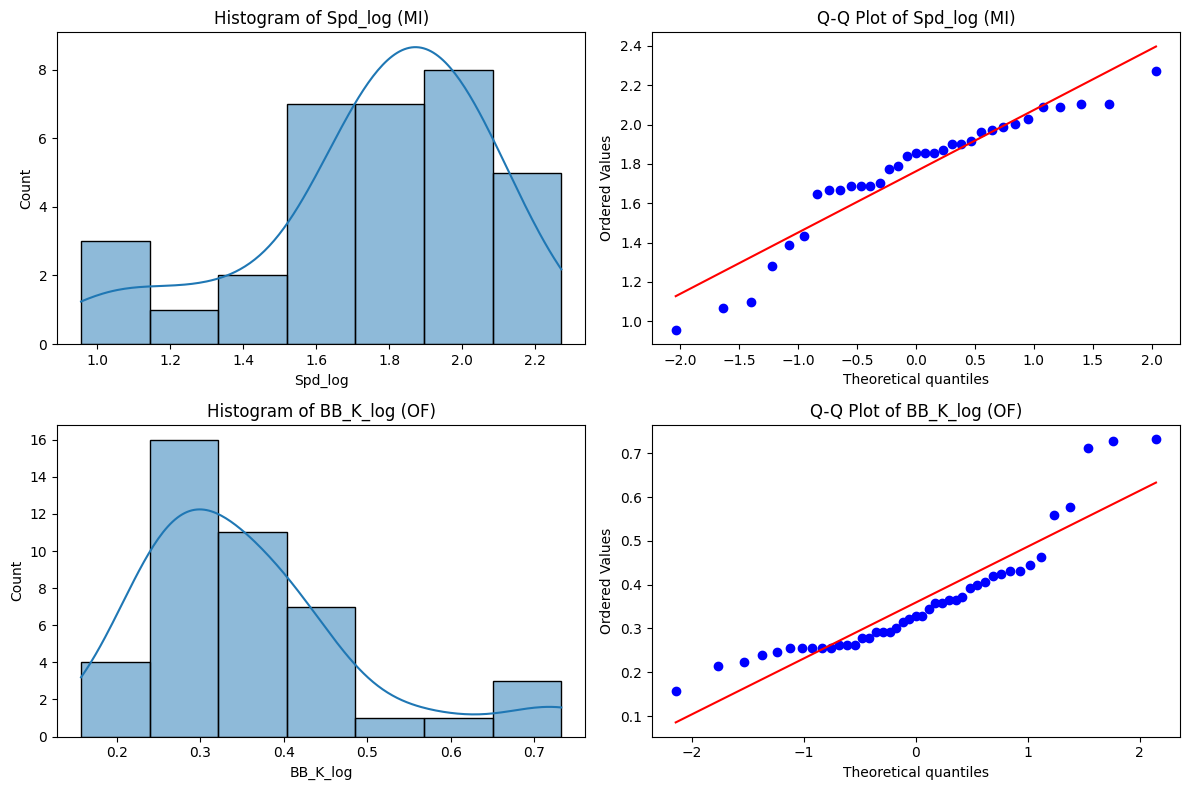

In [18]:
## Visually checking if it will slightkly meet normality assumptiojn ###


import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Create subplots for histograms and Q-Q plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Histogram for Spd_log in MI
sns.histplot(mlb_stats2[mlb_stats2['pos_cat'] == 'MI']['Spd_log'].dropna(), kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Spd_log (MI)")

# Q-Q plot for Spd_log in MI
stats.probplot(mlb_stats2[mlb_stats2['pos_cat'] == 'MI']['Spd_log'].dropna(), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Q-Q Plot of Spd_log (MI)")

# Histogram for BB_K_log in OF
sns.histplot(mlb_stats2[mlb_stats2['pos_cat'] == 'OF']['BB_K_log'].dropna(), kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Histogram of BB_K_log (OF)")

# Q-Q plot for BB_K_log in OF
stats.probplot(mlb_stats2[mlb_stats2['pos_cat'] == 'OF']['BB_K_log'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of BB_K_log (OF)")

plt.tight_layout()
plt.show()
#

In [19]:

## Taking the square root transformation to improve normality ##

mlb_stats2['Spd_sqrt'] = np.sqrt(mlb_stats2['Spd'])
mlb_stats2['BB_K_sqrt'] = np.sqrt(mlb_stats2['BB/K'])


<ipython-input-19-1d2a831242f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlb_stats2['Spd_sqrt'] = np.sqrt(mlb_stats2['Spd'])
<ipython-input-19-1d2a831242f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlb_stats2['BB_K_sqrt'] = np.sqrt(mlb_stats2['BB/K'])


In [20]:
## Re-running the Wilk test again after applying the square root transformation
import scipy.stats as stats
import numpy as np

# List of transformed dependent variables to check
transformed_dep_vars = ['Spd_sqrt', 'BB_K_sqrt']

# Group data by position category
grouped = mlb_stats2.groupby('pos_cat')

# Loop through each group and perform Shapiro-Wilk test for transformed variables
for group_name, group_data in grouped:
    print(f"Testing normality for position group: {group_name}")
    for var in transformed_dep_vars:
        stat, p_value = stats.shapiro(group_data[var].dropna())  # Drop NaN values if any
        print(f"{var}: W={stat:.3f}, p={p_value:.3f}")
        if p_value < 0.05:
            print(f"  → {var} is NOT normally distributed (p < 0.05)")
        else:
            print(f"  → {var} is normally distributed (p ≥ 0.05)")
    print("-" * 40)


Testing normality for position group: CI
Spd_sqrt: W=0.976, p=0.573
  → Spd_sqrt is normally distributed (p ≥ 0.05)
BB_K_sqrt: W=0.985, p=0.879
  → BB_K_sqrt is normally distributed (p ≥ 0.05)
----------------------------------------
Testing normality for position group: MI
Spd_sqrt: W=0.938, p=0.058
  → Spd_sqrt is normally distributed (p ≥ 0.05)
BB_K_sqrt: W=0.981, p=0.813
  → BB_K_sqrt is normally distributed (p ≥ 0.05)
----------------------------------------
Testing normality for position group: OF
Spd_sqrt: W=0.987, p=0.905
  → Spd_sqrt is normally distributed (p ≥ 0.05)
BB_K_sqrt: W=0.881, p=0.000
  → BB_K_sqrt is NOT normally distributed (p < 0.05)
----------------------------------------


In [21]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Function to compute Box's M test
def box_m_test(df, dep_vars, group_col):
    groups = df[group_col].unique()
    cov_matrices = [df[df[group_col] == group][dep_vars].cov().values for group in groups]

    pooled_cov = sum(cov_matrices) / len(groups)  # Average covariance matrix
    inv_pooled_cov = np.linalg.inv(pooled_cov)  # Inverse of pooled covariance matrix

    log_dets = [np.log(np.linalg.det(cov)) for cov in cov_matrices]
    log_det_pooled = np.log(np.linalg.det(pooled_cov))

    n = [len(df[df[group_col] == group]) for group in groups]
    p = len(dep_vars)
    k = len(groups)

    # Compute Box's M statistic
    M = (sum(n) - k) * log_det_pooled - sum([(n[i] - 1) * log_dets[i] for i in range(k)])
    c = ((2 * p**2 + 3 * p - 1) * (k - 1)) / (6 * (p + 1) * (sum(n) - k))
    chi_square = M * (1 - c)
    df = (p * (p + 1) * (k - 1)) / 2
    p_value = 1 - stats.chi2.cdf(chi_square, df)

    return M, chi_square, df, p_value

# Define transformed dependent variables
transformed_dep_vars = ['Spd_sqrt', 'BB_K_sqrt', 'Def', 'BABIP']  # Keeping other MANOVA variables

# Run Box's M test after transformation
M_stat, chi2_stat, df, p_val = box_m_test(mlb_stats2, transformed_dep_vars, 'pos_cat')

# Print results
print(f"Box's M Test Results After Square Root Transformation:")
print(f"M Statistic: {M_stat:.3f}")
print(f"Chi-Square Statistic: {chi2_stat:.3f}")
print(f"Degrees of Freedom: {df}")
print(f"P-value: {p_val:.5f}")

# Interpretation
if p_val < 0.05:
    print("→ The assumption of homogeneity of covariance matrices is VIOLATED (p < 0.05).")
else:
    print("→ The assumption of homogeneity of covariance matrices is MET (p ≥ 0.05).")


Box's M Test Results After Square Root Transformation:
M Statistic: 22.763
Chi-Square Statistic: 22.175
Degrees of Freedom: 20.0
P-value: 0.33108
→ The assumption of homogeneity of covariance matrices is MET (p ≥ 0.05).


Now that normality and homogeneity of Variance-covariance is met, we can run MANOVA using the transformed variables.

In [34]:
# Run MANOVA
# import statsmodels.api as sm
# from statsmodels.multivariate.manova import MANOVA

from statsmodels.multivariate.manova import MANOVA

#Define the MANOVA model
manova_model = MANOVA.from_formula(' + '.join(transformed_dep_vars) + ' ~ pos_cat', data=mlb_stats2)

# Print the results
print(manova_model.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0164 4.0000 108.0000 1618.5222 0.0000
         Pillai's trace  0.9836 4.0000 108.0000 1618.5222 0.0000
 Hotelling-Lawley trace 59.9453 4.0000 108.0000 1618.5222 0.0000
    Roy's greatest root 59.9453 4.0000 108.0000 1618.5222 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
           pos_cat         Value  Num DF  Den DF  F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.6276 8.0000 216.0000  7.0812 0.0000
            Pillai's trace 0.4124 8.0000 218.

**Key Results:**

**1. Wilks' Lambda (Most Common)**
Value: 0.6276
**F(8, 216) = 7.0812`
p-value = 0.000 (p < 0.05) i.e Significant

**Interpretation:**
Since p < 0.05, at least one dependent variable significantly differs across position groups.
Lower Wilks' Lambda values indicate greater separation between groups.


**2. Pillai’s Trace**
Value: 0.4124
p-value = 0.000 i.e Significant

**Interpretation:**
Confirms significant differences across pos_cat groups.
More robust to violations of assumptions.


**3. Hotelling-Lawley Trace & Roy’s Greatest Root**
Both also show p < 0.05, reinforcing that position groups significantly differ.

In [36]:
## Post Hoc Analysis (Since MANOVA is Significant)

import statsmodels.api as sm
from statsmodels.formula.api import ols

#list of dependent variables
dep_var = ['Spd_sqrt', 'BB_K_sqrt', 'Def', 'BABIP']

# Run ANOVA for each dependent variable
for var in dep_vars:
    model = ols(f"{var} ~ pos_cat", data=mlb_stats2).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA results for {var}:")
    print(anova_table)
    print("\n" + "-"*40 + "\n")

ANOVA results for Spd_sqrt:
             sum_sq     df          F    PR(>F)
pos_cat    3.651033    2.0  12.557032  0.000012
Residual  16.136962  111.0        NaN       NaN

----------------------------------------

ANOVA results for BB_K_sqrt:
            sum_sq     df         F    PR(>F)
pos_cat   0.075920    2.0  2.288793  0.106155
Residual  1.840952  111.0       NaN       NaN

----------------------------------------

ANOVA results for Def:
               sum_sq     df          F        PR(>F)
pos_cat   2366.336971    2.0  15.884061  8.578098e-07
Residual  8268.143731  111.0        NaN           NaN

----------------------------------------

ANOVA results for BABIP:
            sum_sq     df         F   PR(>F)
pos_cat   0.004862    2.0  3.016391  0.05301
Residual  0.089457  111.0       NaN      NaN

----------------------------------------



**ANOVA Results Summary**
1. Significant Differences (p < 0.05)   
   Spd_sqrt (Speed Rating) → p = 0.000012 (Significant!)
   Def (Defensive Rating) → p = 8.57e-07 (Highly Significant!)

** Interpretation:**

Spd and Def significantly differ between position groups.
Further analysis is needed to determine which specific groups differ (i.e., OF vs. CI, MI vs. CI, etc.).


2. Non-Significant Differences (p > 0.05)
   BB_K_sqrt (Walk-to-Strikeout Ratio) → p = 0.106 (Not Significant)
   BABIP (Batting Average on Balls in Play) → p = 0.053 (Borderline, but Not Significant)

** Interpretation:**

No strong evidence that BB_K_sqrt or BABIP differs across position groups.
No need for post-hoc analysis for these variables since ANOVA was not significant.


In [ ]:
## Tukey's Post-hoc test(Pairwise Comparisons)
#Now that Spd_sqrt (Speed) and Def (Defense) were significant in ANOVA, we need to check which specific position groups differ.

In [38]:
!pip install statsmodels

In [39]:
#Running the Tukey's HSD Test

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# List of significant variables to test
sig_vars = ['Spd_sqrt', 'Def']

for var in sig_vars:
    print(f"Tukey's HSD Test for {var}:")

    # Perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=mlb_stats2[var], groups=mlb_stats2['pos_cat'], alpha=0.05)

    # Print results
    print(tukey)
    print("\n" + "-"*50 + "\n")


Tukey's HSD Test for Spd_sqrt:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    CI     MI   0.3873 0.0001  0.1718 0.6028   True
    CI     OF   0.3734 0.0001  0.1718 0.5751   True
    MI     OF  -0.0139 0.9865 -0.2235 0.1958  False
---------------------------------------------------

--------------------------------------------------

Tukey's HSD Test for Def:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    CI     MI  10.6465    0.0    5.768  15.525   True
    CI     OF   1.2597 0.7896  -3.3052  5.8245  False
    MI     OF  -9.3868    0.0 -14.1317 -4.6419   True
-----------------------------------------------------

--------------------------------------------------



**Interpretation of Tukey's HSD Test Results**  
Tukey's test helps identify **which specific position groups (CI, MI, OF) significantly differ** in **Spd_sqrt (Speed)** and **Def (Defense)**.


**1. Spd_sqrt (Speed) Results**
 **Interpretation (Speed Differences)**

**CI vs. MI → Significant (p = 0.0001)** → CI has significantly **higher speed** than MI.
**CI vs. OF → Significant (p = 0.0001)** → CI has significantly **higher speed** than OF.
**MI vs. OF → Not Significant (p = 0.9865)** → MI and OF have **similar speed**.

**Conclusion:** **Corner Infielders (CI) are significantly faster than both Middle Infielders (MI) and Outfielders (OF).** However, **MI and OF do not differ in speed.**



**2. Def (Defensive Rating) Results**

**Interpretation (Defensive Differences)**
**CI vs. MI → Significant (p = 0.000)** → CI has a **much higher** defensive rating than MI.
**CI vs. OF → Not Significant (p = 0.7896)** → CI and OF **have similar defense**.
**MI vs. OF → Significant (p = 0.000)** → MI has a **much lower** defensive rating than OF.

**Conclusion:**  
**Middle Infielders (MI) have significantly lower defense** than both CI and OF.
**Corner Infielders (CI) and Outfielders (OF) do not differ in defense**.


**Final Summary**
1. **Speed (Spd_sqrt)**
   **CI is significantly faster than both MI and OF.**
   **MI and OF have similar speed.**
  
2. **Defense (Def)**
   **MI has significantly lower defensive ratings than both CI and OF.**
   **CI and OF have similar defense.**



<Figure size 1200x600 with 0 Axes>

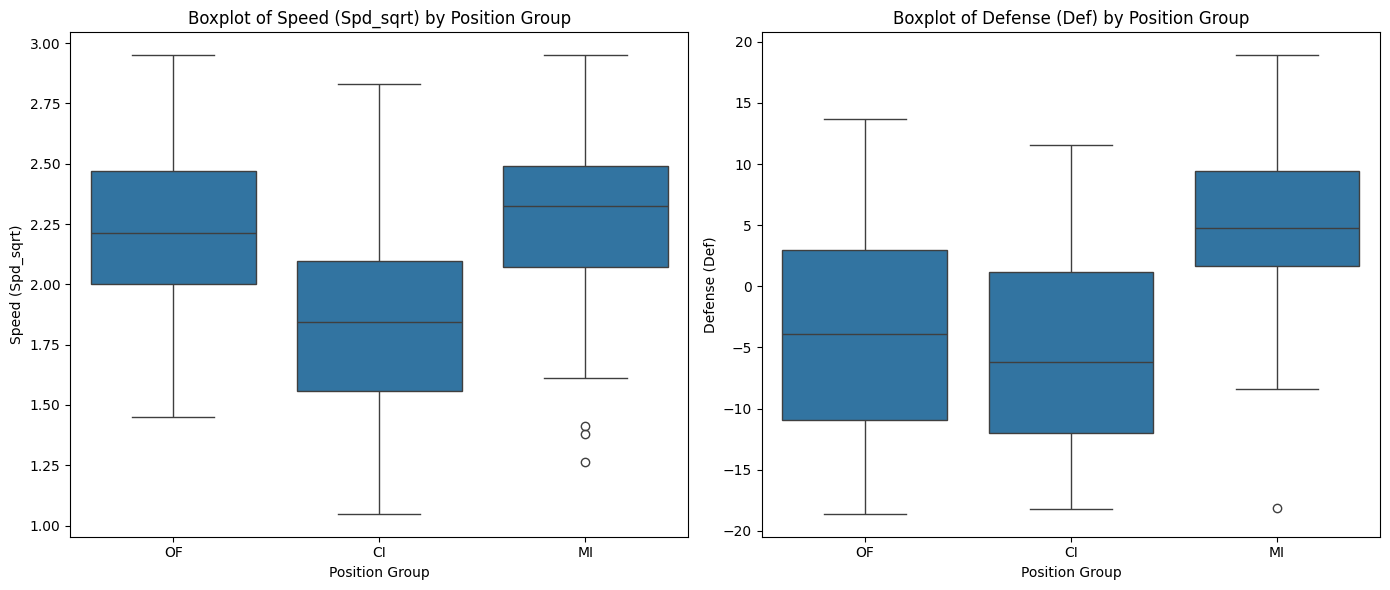

In [41]:
## Visualizing the differences using boxplots for the speed and defense accross position groups
import matplotlib.pyplot as plt
import seaborn as sns

#set figure size
plt.figure(figsize = (12, 6))

#create boxplots for Spd_sqrt (speed) and Def (Defense)
fig, axes = plt.subplots(1,2, figsize = (14,6))

#Boxplot dor Spd_sqrt (Speed)
sns.boxplot(x = 'pos_cat', y = 'Spd_sqrt', data = mlb_stats2, ax = axes[0])
axes[0].set_title('Boxplot of Speed (Spd_sqrt) by Position Group')
axes[0].set_xlabel('Position Group')
axes[0].set_ylabel('Speed (Spd_sqrt)')


#Boxplot for Def (Defense)
sns.boxplot(x = 'pos_cat', y = 'Def', data = mlb_stats2, ax = axes[1])
axes[1].set_title('Boxplot of Defense (Def) by Position Group')
axes[1].set_xlabel('Position Group')
axes[1].set_ylabel('Defense (Def)')


#Display
plt.tight_layout()
plt.show()
